## Physics Challenge

Welcome to the physics challenge of the MQST Qiskit Fall Fest!

In this challenge, you will study a spin system, a prototypical problem in condensed matter physics. Using VQE algorithm, you will find that spins can manifest different phases and behaviours even when they rest at their ground state.

#### Cell for installing necessary packages:

In [1]:
# Uncomment to install the necessary packages
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install jupyter
!pip install qiskit[visualization]==1.2
# # For Local Linux or Mac, you can use the following command:
# # !pip install 'qiskit[visualization]'==1.2
!pip install qiskit_algorithms
!pip install qiskit_aer >= 0.14
!pip install qiskit_ibm_runtime
!pip install qiskit_ibm_transpiler

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/4.6 MB ? eta -:--:--
   ---------------------------------------- 4.6/4.6 MB 25.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 16.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/17.8 MB ? eta -:--:--
   --------------- ------------------------ 7.1/17.8 MB 33.6 MB/s eta 0:00:01
   ----------------------------- ---------- 13.1/17.8 MB 32.9 MB/s eta 0:00:01
   ---------------------------------------- 17.8/17.8 MB 29.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 6.2/6.2 MB 34.5 MB/s eta 0:00:00
   -----

## 1 - One ring to rule the spins

To simulate a quantum system, we need to determine the interactions between the quantum particles that constitute it by defining its Hamiltonian operator.
The system will be a ring that follows the XXZ Heisenberg model [[Ref.1]](#REF)<a class="anchor" id="Ref1"></a>, given by

$$ H_{XXZ} = -\frac{1}{4}\sum_{i=1}^N \sigma_i^x\sigma_{i+1}^x + \sigma_i^y\sigma_{i+1}^y + \Delta \, \sigma_i^z\sigma_{i+1}^z \,.$$

Here, $N$ is the number of spin-1/2 particles, $\Delta$ is the anisotropy parameter, and $\sigma^x_i$, $\sigma^y_i$, and $\sigma^z_i$ are Pauli operators, where the subscripts label the qubit they act on.
Furthermore, we impose the periodic boundary condition $\sigma^u_{i+N}=\sigma^u_{i}$ to make the object rest on a ring shape.
Note that only qubits next to each other interact, which means that we are restricting the interactions to first neighbours.

<p style="text-align: center"><img src="https://i.imgur.com/mw775Nx.png" width=400></p>

This model captures a rich range of behaviours throughout its phase diagram.
First off, for $\Delta=1$, the model converges to the isotropic Heisenberg Hamiltonian (XXX), where all the terms have the same coupling strength.
As we vary $\Delta$, the system can be in three phases:

- $\Delta> 1$: the **ferromagnetic** phase, where all spins point in the same direction.
- $-1<\Delta<1$: the **paramagnetic** or critical phase, where the spins are completely disordered.
- $\Delta<-1$: the **anti-ferromagnetic** phase, where neighboring spins are anti-aligned.

To start, **consider $N=12$ for all the calculations**.


## 1.1 - Ground state energy of the XXZ model

Quantum systems can be naturally found in their ground state (GS).
Thus, the first step is to learn to prepare GSs with the quantum computer.
A prominent approach to do so is through the **Variational Quantum Eigensolver (VQE)** algorithm [[Ref. 2]](#REF)<a class="anchor" id="Ref2"></a>.

Interestingly, the energy spectrum of the $H_{XXZ}$ model can be obtained analytically using the _Bethe ansatz_. For $\Delta>1$, the system is in the _ferromagnetic phase_, in which all the spins in the GS point towards the same direction. This GS energy $\epsilon_{GS}$ is known to be:

$$\epsilon_{GS}=-N\frac{\Delta}{4}\,.$$

### Prepare a simple $N$-qubit state to represent a GS wave function in the ferromagnetic phase. Compute its energy taking the expectation value of the Hamiltonian to confirm the theoretical result $\epsilon_{GS}$ for $\Delta=4$

> !!! Notice: The given empty functions are there to make your life and the organizers life easier, with a common frame, but if you think of another solutions go for it !!!

In [1]:
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector


def nqubit_ferromagnetic_gs(nqubits: int) -> np.ndarray:
    """Returns the ground state of a n-qubit ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        state (np.ndarray): The ground state of the system.
    """

    #state = np.array([1.] + [0.]*2**(nqubits-1), dtype=np.complex128) # why?
    # I would say the gs of a ferromagnetic Ising model is the state with all spins aligned
    state = np.array([0]*nqubits, dtype=np.complex128)

    return state


def nqubit_ferromagnetic_gs_circuit(state_vector: np.ndarray) -> QuantumCircuit:
    """
    Returns the energy of the ground state of a n-qubit ferromagnetic Ising model.

    Args:
        state_vector (np.ndarray): The state vector of the system.

    Returns:
        circuit (qiskit.QuantumCircuit): The circuit that prepares the state.
    """
    
    nqubits = len(state_vector)
    circuit = QuantumCircuit(nqubits) # this directly prepares the |0000...0> state

    return circuit


def get_string_vector(gate, nqubits):

    string_vector = []

    gate_string = gate + gate
    identity_char = "I"

    for index in range(nqubits-1):
        identities_before = identity_char*index
        identities_after = identity_char*(nqubits - index - 2)
        string = identities_before + gate_string + identities_after
        string_vector.append(string)

      # index = nqubits - 1
    string = gate + identity_char*(nqubits - 2) + gate
    string_vector.append(string)

    return string_vector


def nqubit_XXZ_hamiltonian(nqubits: int, delta: float) -> SparsePauliOp:
    """Returns the Hamiltonian of a n-qubit ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
    """

    # The XX applies a X operator on qubit 0, and an X operator on qubit 1
    XX = SparsePauliOp('XX')
    # The YY applies a Y operator on qubit 0, and an Y operator on qubit 1
    YY = SparsePauliOp('YY')
    # The ZZ applies a Z operator on qubit 0, and a Z operator on qubit 1
    ZZ = SparsePauliOp('ZZ')

    identity_char = "I"
    energy_factor = -0.25

    hamiltonian = SparsePauliOp(identity_char*nqubits, coeffs=0. + 0.j)

    string_X = get_string_vector("X",nqubits)
    string_Y = get_string_vector("Y",nqubits)
    string_Z = get_string_vector("Z",nqubits)
    len_strings = len(string_X)
    for index in range(len_strings):
      hamiltonian += energy_factor*(SparsePauliOp(string_X[index]) + SparsePauliOp(string_Y[index]) + delta*SparsePauliOp(string_Z[index]))

    return hamiltonian


def compute_expected_value(circuit: QuantumCircuit, hamiltonian: SparsePauliOp) -> float:
    """Returns the expected value of the prepared state of the given circuit, and the passed operator.

    Args:
        circuit (qiskit.circuit.QuantumCircuit): The circuit that prepares the state.
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.

    Returns:
        energy_gs (float): The energy of the circuit state.
    """
    
    state = Statevector.from_instruction(circuit)
    energy_gs = state.expectation_value(hamiltonian).real

    return energy_gs


Testing it works:
> (Take it as an example, edit it if your solution differs from the given one)

In [ ]:
# Parameters
nqubits = 12
delta = 4

# Computations
fm_gs_vector = nqubit_ferromagnetic_gs(nqubits)
fm_gs_circuit = nqubit_ferromagnetic_gs_circuit(fm_gs_vector)
fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
fm_gs_energy = compute_expected_value(fm_gs_circuit, fm_hamiltonian)

print(f"Expected energy: {-nqubits*delta/4}, obtained energy: {fm_gs_energy}")

Expected energy: -12.0, obtained energy: -12.0


State preparation is not always that straightforward.
In the _anti-ferromagnetic phase_ (for $\Delta<-1$), the GS wave function is more difficult to prepare, as it consists of a non-trivial superposition of the computational basis states.

### Use an exact numerical solver to obtain the GS energy for $\Delta=-2$.
Hint, you may want to use sparse matrices to perform the exact diagonalization.

In [3]:
def obtain_first_hamiltonian_eigenvalue(hamiltonian: SparsePauliOp) -> tuple[np.ndarray, float]:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the exact diagonalization method to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian to diagonalize.

    Returns:
        state (np.ndarray): The ground state of the system.
        energy_gs (float): The energy of the ground state.
    """
    
    hamiltonian_matrix = hamiltonian.to_matrix()
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix)
    state = eigenvectors[:, 0]
    energy_gs = eigenvalues[0]

    return state, energy_gs

Testing the numerical diagonalization method:
> (Take it as an example, edit it if your solution differs from the given one)

In [8]:
nqubits = 12
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
anti_fm_numerical_energy = obtain_first_hamiltonian_eigenvalue(anti_fm_hamiltonian)[1]

print(f"Obtained energy: {anti_fm_numerical_energy}")

Obtained energy: -7.460117375510892


Knowing the answer now, lets try and do the same as before, try to guess an initial guess circuit, for which we will check its expected value, and see if it coincides with the value we got from the exact diagonalization:

In [9]:
def nqubit_anti_fm_initial_guess_circuit(nqubits: int) -> QuantumCircuit:
    """Returns the initial guessed circuit, for the ground state of the anti-ferromagnetic case.
    
    Args:
        nqubits (int): The number of qubits in the system.
    
    Returns:
        circuit (qiskit.QuantumCircuit): The circuit that prepares the state.
    """
    
    # The initial guess for the antiferromagnetic case is the state with all neigbouring spins antiparallel, starting with |0>
    circuit = QuantumCircuit(nqubits)
    for qubit in range(0,nqubits,2):
        circuit.x(qubit)
    return circuit

Testing the initial guess circuit:
> (Take it as an example, edit it if your solution differs from the given one)

In [10]:
nqubits = 12
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
anti_fm_initial_guess_circuit = nqubit_anti_fm_initial_guess_circuit(nqubits)

anti_fm_initial_guess_energy = compute_expected_value(anti_fm_initial_guess_circuit, anti_fm_hamiltonian)

print(f"Minimum, numerical energy: {anti_fm_numerical_energy}, Obtained energy: {anti_fm_initial_guess_energy}")

Minimum, numerical energy: -7.460117375510892, Obtained energy: -6.0


Was it close? Yes, no? Can you think of a better solutions?

------

### Use the VQE algorithm to estimate the GS energy for $\Delta=-2$

In the VQE algorithm, we use a parameterized circuit to prepare the GS of our Hamiltonian.
We start with an initial guess of the circuit parameters and optimize them to minimize the expectation value of the Hamiltonian.
This naturally brings us (close) to the GS of the system, as it is, by definition, the state with the lowest energy.

Use the **VQE algorithm ([VQE](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html#qiskit_algorithms.VQE))** to prepare the GS of the Hamiltonian for the same value of $\Delta$.
You should try to achieve the closest estimate to the actual GS energy using an **ansatz consisting of three layers of single- and two-qubit gates (controlled-X), where two-qubit gates connect only near neighbor qubits**.
Furthermore, among the different possibilities for the optimizers that you can choose from, use the **Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html#qiskit_algorithms.optimizers.SPSA)) optimizer**.

> Hint: [EfficientSU2](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2) can help you to generate the ansatz circuit if you do not want to code every gate by hand.

In [84]:
import numpy as np
from qiskit_algorithms.optimizers import *
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


def create_ansatz_vqe(n_qubits: int, ansatz_type: str, nlayers: int) -> QuantumCircuit:
    """Returns the ansatz for the VQE algorithm.

    Args:
        n_qubits (int): The number of qubits in the system.
        ansatz_type (str): The type of two qubit gates used in the ansatz.
        nlayers (int): The number of layers in the ansatz.

        --You can use extra Args if you need it

    Returns:
        ansatz (qiskit.QuantumCircuit): The ansatz for the VQE algorithm.
    """

    # I don't understand what they mean by ansatz_type, as in EfficientSU2 you can't choose the two qubit gates (they are always CX)
    # I have supposed that ansatz_type refers to the entanglement type, but it's not specified in the function signature

    ansatz = EfficientSU2(n_qubits, reps=nlayers, entanglement=ansatz_type)

    return ansatz


def nqubit_anti_fm_gs_energy_vqe(
    hamiltonian: SparsePauliOp, ansatz: QuantumCircuit, initial_params: np.ndarray, optimizer: Optimizer, backend=AerSimulator()
) -> float:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the VQE algorithm to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.
        backend (qiskit.providers.Backend): The backend to use.

        --You can use extra Args if you need it

    Returns:
        gs_energy (float): The ground state of the system.

    """

    estimator = Estimator(backend)
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

    def run_ansatz(ansatz, params, estimator, hamiltonian):
        return estimator.run([[ansatz.assign_parameters(params), hamiltonian]]).result()[0].data.evs
    
    def ansatz_to_optimize(params):
        return run_ansatz(ansatz_isa, params, estimator, hamiltonian_isa)

    result = optimizer.minimize(ansatz_to_optimize, initial_params)
    optimal_params = result.x
    gs_energy = run_ansatz(ansatz_isa, optimal_params, estimator, hamiltonian_isa)
    
    return gs_energy

Testing the VQE functions:
> (Take it as an example, edit it if your solution differs from the given one)

In [88]:
nqubits = 12
delta = -2
nlayers = 1 # provisional
optimizer = SPSA(maxiter=100)

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
#ansatz_anti_fm = create_ansatz_vqe(nqubits, delta, nlayers) # why do they pass an integer (delta) as ansatz_type (str)?
ansatz_anti_fm = create_ansatz_vqe(nqubits, "linear", nlayers) # I have supposed that ansatz_type refers to the entanglement type

# provisional random initial parameters, it would be better to initialize them such that the initial state is |010101...>
initial_params = 2*np.pi*np.random.random(ansatz_anti_fm.num_parameters)

anti_fm_vqe_energy = nqubit_anti_fm_gs_energy_vqe(anti_fm_hamiltonian, ansatz_anti_fm, initial_params, optimizer)

print(f"Minimum, numerical energy: {anti_fm_numerical_energy}, Obtained VQE energy: {anti_fm_vqe_energy}")

Minimum, numerical energy: -7.460117375510892, Obtained VQE energy: -5.05224609375


## 1.2 - Ansatz expressability

This method has several aspects that can be tuned, such as the shape of the ansatz or the optimization algorithm to find the parameters. These are important factors in more elaborate quantum simulations.
To better understand the role of these parameters, re-implement the method to solve the previous problem ($H_{XXZ}$ with $\Delta=-2$) and compare the results obtained with with different combinations of ansatz and classical optimizers.

 - **Ansatz**:

   - Choose the type of entanglement between ‘linear’, ‘pairwise’, ‘circular’.

 - **Optimizers**:

   - Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html#qiskit_algorithms.optimizers.SPSA)) ;
   - Constrained Optimization By Linear Approximation ([COBYLA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.COBYLA.html#qiskit_algorithms.optimizers.COBYLA));
   - Sequential Least SQuares Programming ([SLSQP](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SLSQP.html#qiskit_algorithms.optimizers.SLSQP)).

For all types of ansatz above, fix only 3 layers of each type of gate. Compare the 9 different combinations of ansatz and optimizer to understand which one performs better both in terms of the accuracy error obtained, and the time and number of steps to converge.

### Plot the estimate of the GS energy as a function of the optimization steps for all the combinations of optimizer and ansatz listed above. Discuss which combination is the best one for this specific problem.

> Hint: You might need to do several Python blocks (ant their Markdown titles), here. Maybe one for each combination of ansatz and optimizer (or not), and then another one to compare all of them with all the Plots is recommendable.

> Hint: take a look at predefined circuits like [TwoLocal](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal), and see how they work with the different entanglements and gate blocks.

In [118]:
import time
import itertools

entanglement_list = ["linear", "pairwise", "circular"]
optimizer_list = [SPSA(), COBYLA(), SLSQP()] # with default maxiter

nqubits = 12
delta = -2
nlayers = 3

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)

accuracy = []
time_ls = []

for optimizer, entanglement_type in list(itertools.product(optimizer_list, entanglement_list)):
    ansatz_anti_fm = create_ansatz_vqe(nqubits, entanglement_type, nlayers)
    initial_params = 2*np.pi*np.random.random(ansatz_anti_fm.num_parameters) # provisional random initial parameters
    start = time.time()
    anti_fm_vqe_energy = nqubit_anti_fm_gs_energy_vqe(anti_fm_hamiltonian, ansatz_anti_fm, initial_params, optimizer)
    end = time.time()
    accuracy.append(abs(anti_fm_vqe_energy-anti_fm_numerical_energy))
    time_ls.append(end-start)
    print(f"Entanglement type: {entanglement_type}, Optimizer: {optimizer.__class__.__name__}, Accuracy: {accuracy[-1]}, Time: {time_ls[-1]}s")

# This has been executed with 3 qubits and 1 layer for provisional testing, as my laptop takes too long to run it with 12 qubits and 3 layers
# That's why the accuracy is very high, as it's comparing the gs energy of the 12 qubit system with the 3 qubit system

Entanglement type: linear, Optimizer: SPSA, Accuracy: 6.359775578635892, Time: 25.39467692375183s
Entanglement type: pairwise, Optimizer: SPSA, Accuracy: 6.268955266135892, Time: 26.3699209690094s
Entanglement type: circular, Optimizer: SPSA, Accuracy: 6.152256047385892, Time: 32.27198815345764s
Entanglement type: linear, Optimizer: COBYLA, Accuracy: 6.282871281760892, Time: 15.845051288604736s
Entanglement type: pairwise, Optimizer: COBYLA, Accuracy: 6.281406438010892, Time: 12.829721689224243s
Entanglement type: circular, Optimizer: COBYLA, Accuracy: 6.377109563010892, Time: 12.989079713821411s
Entanglement type: linear, Optimizer: SLSQP, Accuracy: 8.306552922385892, Time: 138.27596616744995s
Entanglement type: pairwise, Optimizer: SLSQP, Accuracy: 7.918369328635892, Time: 157.57009720802307s
Entanglement type: circular, Optimizer: SLSQP, Accuracy: 7.266513859885892, Time: 141.9601182937622s


Entanglement type: linear, Optimizer: SPSA, Energy: -1.1455078125
Entanglement type: pairwise, Optimizer: SPSA, Energy: -1.173828125
Entanglement type: circular, Optimizer: SPSA, Energy: -1.25341796875


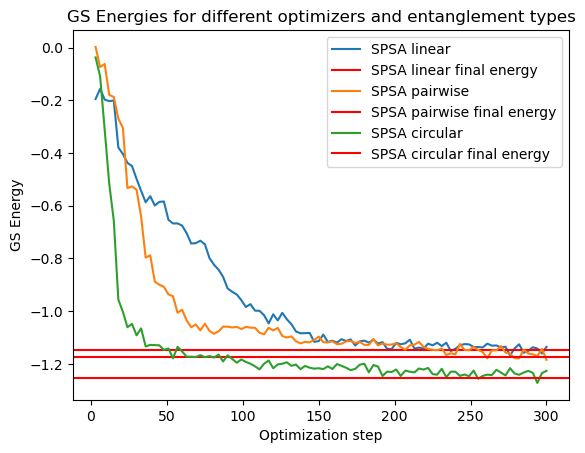

In [113]:
import matplotlib.pyplot as plt


def nqubit_anti_fm_gs_energy_vqe_with_intermediate_steps(
    hamiltonian: SparsePauliOp, ansatz: QuantumCircuit, initial_params: np.ndarray, optimizer: str, backend=AerSimulator()
) -> float:
    """Returns the ground state energy of a n-qubit antiferromagnetic XXZ Heisenberg model
       using VQE, and stores intermediate parameters.

    Args:
        hamiltonian (SparsePauliOp): The Hamiltonian of the system.
        ansatz (QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (Optimizer): The optimizer to use.
        backend (Backend): The backend to use.
    
    Returns:
        float: Ground state energy.
    """
    estimator = Estimator(backend)
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

    def run_ansatz(ansatz, params, estimator, hamiltonian):
        circuit = ansatz.assign_parameters(params)
        return estimator.run([[circuit, hamiltonian]]).result()[0].data.evs

    def ansatz_to_optimize(params):
        return run_ansatz(ansatz_isa, params, estimator, hamiltonian_isa)

    # Lists to store intermediate parameters and steps
    intermediate_params = []
    intermediate_energies = []
    step = []

    # Callback function to store intermediate parameters
    def store_intermediate_result(eval_count, parameters, mean, step_size, acceptance):
        step.append(eval_count)
        intermediate_params.append(parameters)  # Save parameters from the current iteration
        intermediate_energies.append(mean)  # Save the mean energy from the current iteration

    # Set the optimizer with the callback
    if optimizer == 'SPSA':
        optimizer = SPSA(maxiter=100, callback=store_intermediate_result)
    elif optimizer == 'COBYLA':
        optimizer = COBYLA(maxiter=100, callback=store_intermediate_result)
    elif optimizer == 'SLSQP':
        optimizer = SLSQP(maxiter=100, callback=store_intermediate_result)

    # Perform optimization
    result = optimizer.minimize(ansatz_to_optimize, initial_params)
    optimal_params = result.x
    gs_energy = run_ansatz(ansatz_isa, optimal_params, estimator, hamiltonian_isa)

    return gs_energy, intermediate_energies, step

nqubits = 12
delta = -2
nlayers = 3

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
initial_params = 2*np.pi*np.random.random(ansatz_anti_fm.num_parameters)

entanglement_list = ["linear", "pairwise", "circular"]
optimizer_list = ["SPSA", "COBYLA", "SLSQP"]
optimizer_list = ['SPSA']

for optimizer, entanglement_type in list(itertools.product(optimizer_list, entanglement_list)):
    ansatz_anti_fm = create_ansatz_vqe(nqubits, entanglement_type, nlayers)
    anti_fm_vqe_energy, intermediate_params, step = nqubit_anti_fm_gs_energy_vqe_with_intermediate_steps(anti_fm_hamiltonian, ansatz_anti_fm, initial_params, optimizer)
    plt.plot(step, intermediate_params, label=optimizer+' '+entanglement_type)
    plt.axhline(y=anti_fm_vqe_energy, color='r', linestyle='-', label=optimizer+' '+ entanglement_type + " final energy")
    print(f"Entanglement type: {entanglement_type}, Optimizer: {optimizer}, Energy: {anti_fm_vqe_energy}")

plt.xlabel("Optimization step")
plt.ylabel("GS Energy")
plt.title("GS Energies for different optimizers and entanglement types")
plt.legend()
plt.show()

# The plotted graph was obtained with 3 qubits and 1 layer just for provisional testing, as my laptop takes a lot of time to run the code with 12 qubits and 3 layers

## 1.3 - Phase diagram

As we have introduced above, the full phase diagram of the $H_{XXZ}$ model encompasses a rich range of behaviours:

- For $\Delta>1$, we have a **ferromagnetic** phase.
- For $-1<\Delta<1$, we have a **paramagnetic** phase.
- For $\Delta\leq-1$, we have an **anti-ferromagnetic** phase.

Use the best combination of optimizer and ansatz that you have found before to prepare the GS of the system for different values of $\Delta$ to reconstruct the phase diagram.
Consider, at least, the values of $\Delta=\{-2, -1, 0, 1, 2\}$.
These will allow you to probe the properties of the GS in each phase.
If you can afford to use more points within the $\Delta\in[-2, 2]$ range, go for it!

Taking the exact solution (obtained by exact diagonalization or any other classical method that you might know) as a reference, try to improve the ansatz, e.g., adding more layers, to obtain a better representation of the GS of the system.

Once you find the optimal parameters for your best ansatz, use it to compute the expectation value of the **magnetization** of the system along the $z$-axis
$$
M \equiv \frac{1}{2N} \sum_{i=1}^{N} \left\langle \sigma_{i}^{z} \right\rangle\,,
$$
the **staggered magnetization**
$$
M_{st} \equiv \frac{1}{2N}\sum_{i=1}^N (-1)^i\left\langle\sigma_i^z\right\rangle\,,
$$
as well as the expectation value of the **nearest neighbour correlator**
$$
C \equiv \frac{1}{4N} \sum_{i=1}^{N}\left\langle \sigma_{i}^{z} \sigma_{i+1}^{z}  \right\rangle\,.
$$
Plot these observables as a function of $\Delta$.
You will need to prepare the GS multiple times to estimate these averages from the measurement statistics.

### Plot $M$, $M_{st}$ and $C$ as a function of $\Delta$ and comment on the GS properties you can infer from these observables.
> Tip: To avoid finding degenerate GSs, try to energetically favour one of those by adding an external magnetic field in one direction in the Hamiltonian $H_{XXZ} + \delta\sigma_0^z$ with small $\delta$. This will ease the computation of the previous observables.

In [ ]:
def compute_magnetization(state_vector: np.ndarray) -> float:
    """Returns the magnetization of the system, given a state,

    Args:
        state_vector (np.ndarray): Desired state, to compute the magnetization from.

    Returns:
        magnetization (float): The average magnetization of the system, in the given state.
    """
    # Your code here

    return magnetization


def compute_staggered_magnetization(state_vector: np.ndarray) -> float:
    """Returns the staggered magnetization of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the staggered magnetization from.

    Returns:
        staggered_magnetization (float): The average magnetization of the system, in the given state.
    """
    # Your code here

    return staggered_magnetization


def compute_nearest_neighbour_correlator(state_vector: np.ndarray) -> float:
    """Returns the nearest neighbour correlator of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the nearest neighbour correlator from.

    Returns:
        nearest_neighbour_correlator (float): The average magnetization of the system, in the given state.
    """
    # Your code here

    return nearest_neighbour_correlator

Now you also, will need a VQE algorithm, that returns the `optimal_params` and not only the energy;

In [ ]:
def compute_gs_params_vqe(hamiltonian, ansatz, initial_params, optimizer) -> np.ndarray:
    """Returns the VQE optimal parameters of the circuit, to generate the ground state of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        gs_circuit_params (np.ndarray): The parameters of the circuit.
    """

    # Your code here
    #
    #

    return gs_circuit_params

Now as said before, loop in the deltas, using the best combination of optimizer and ansatz from before:
> (Take it as an example, edit it if your solution differs from the given one)

In [ ]:
optimal_ansatz = ...  # Your code here
optimal_optimizer = ...  # Your code here
optimal_initial_params = ...  # Your code here

nqubits = 12
deltas = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]  # You might edit this list...
hamiltonians: list[SparsePauliOp] = [nqubit_XXZ_hamiltonian(delta=delta) for delta in deltas]


# Your code goes here
#
#

list_params_to_generate_gs = []

for hamiltonian in hamiltonians:
    # Your code goes here
    #
    #

    vqe_optimal_parameters = compute_gs_params_vqe(hamiltonian, optimal_ansatz, optimal_initial_params, optimal_optimizer)
    list_params_to_generate_gs.append(...)

And compute the magnetizations, for the different ground states found:

In [ ]:
magnetizations = []
staggered_magnetizations = []
nearest_neighbour_correlators = []

for params_to_generate_gs in list_params_to_generate_gs:

    gs_circuit_generator: QuantumCircuit = # Your code goes here

    ground_state_vector: np.ndarray = # Your code goes here

    magnetizations.append(compute_magnetization(ground_state_vector))
    staggered_magnetization = compute_staggered_magnetization(ground_state_vector)
    nearest_neighbour_correlator = compute_nearest_neighbour_correlator(ground_state_vector)

Finally Plot the `magnetization`, `staggered_magnetization` and `near-neighbour_correlations`, in function of $\Delta$,

In [ ]:
import matplotlib.pyplot as plt

# Your styling goes here
#
#

plt.plot(deltas, magnetizations, label="Magnetization")
plt.plot(deltas, staggered_magnetizations, label="Staggered Magnetization")
plt.plot(deltas, nearest_neighbour_correlator, label="Nearest-neighbor correlations")

plt.xlabel("$\Delta$")

plt.legend()

## 1.4 - Excited states

Up to here we have just analyzed properties of the ground state of the system using VQE. Can we access excited eigenstates using a quantum circuit?

Check ([VQD](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQD.html#qiskit_algorithms.VQD)) and use it to find the gap between the ground state and the excited state for $\delta=0.1$ and $\Delta=\{−2,−1,0,1,2\}$. How does the gap change as a function of $\Delta$?


In [ ]:
def compute_first_excited_energy_vqd(hamiltonian, ansatz, initial_params, optimizer) -> float:
    """Returns the VQD first excited state energy, of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        first_excited_energy (float): The first excited state energy.
    """

    # Your code here
    #
    #

    return first_excited_energy


def compute_gap(vqd_result):
    """Returns the gap between the ground state and the excited state.

    Args:
        vqd_result (float): Energy of the first excited state, result of the VQD.

    Returns:
        gap (float): The gap between the ground state and the excited state.
    """

    return gap

Now call the functions and plot what ever you consider necessary:

In [1]:
# Your code goes here
#
#

------
> ##### From now on, we won't limit you, so much, on the structure of the solution,
> ##### So be creative, but please, try to keep the solutions clean and [modular](https://medium.com/@tharinduBlog/python-functions-and-modular-programming-c2875d197a6)!
------

## 2 - The ring empire strikes back

Welcome to the second part of the challenge!
You have succeeded on solving a spin system using a quantum hybrid algorithm, so now we will bring the algorithm to its limits and tackle a very hard problem with it. Here you would show all your creativity and ability to improve the work done before.

The Kagome lattice consists of corner-sharing triangles and is characterized by a large degree of geometric frustration, which becomes visible for instance in an antiferromagnetic Heisenberg model: while two of the three spins can be antiparallel, the third one is frustrated—both possible configurations will always contain one good and bad bond and are hence degenerate. This results in a macroscopic degeneracy of configurations which can host new physics. This type of system is expected to form a spin liquid, where the spin distribution does not order even at zero temperature.

The following figure shows a Kagome unit cell of 12 spins, our new system:

<p style="text-align: center"><img src="https://i.imgur.com/67usdUW.png" width=600></p>

For a system like this ruled by the $H_{XXZ}$ hamiltonian, multiple phases can appear, some of them with predicted fractional excitations.

$$ H_{XXZ} = -\frac{1}{4}\sum_{<i, j>}^N \sigma_i^x\sigma_{j}^x + \sigma_i^y\sigma_{j}^y + \Delta \, \sigma_i^z\sigma_{j}^z \,.$$

where $<i,j>$ stands for nearest-neighbors pairs. This is of course a much more complex system that the one you have already studied, but now you have all the tools to face it with promising perspectives.

## 2.1- Repeat and refine

### Find the groundstate of the system for $\Delta = 1$ and compare it with the exact groundstate energy. How is the algorithm performing?



In [ ]:
# Your code here

### Modify the ansatz length and/or shape and/or the optimizer to improve the ground state energy of the system.

In [ ]:
# Your code here

## 2.2- Exploring the phases of this system

Now that you have mastered the convergence of this system, let's give everything to explore new physics (if they appear).

### Find the ground state of this system for $\Delta=\{-2,-1,0,1,2\}$ using the VQE algorithm and compute also $M$, $M_{st}$ and $C$ as a function of $\Delta$ and describe the phases that appear. Can you find any other observable that describes any new phase?

In [ ]:
# Your code here

## 2.3 - Imperfect devices

In the current noisy intermediate-scale quantum (NISQ) devices, the operations are imperfect and the errors accumulate along the execution of the circuit.
In particular, two-qubit operations, such as the CNOT, have the highest errors.

### Find the GS and the first excited state of the Kagome System using a real quantum device ([run-jobs](https://docs.quantum.ibm.com/guides/run-jobs-session)) (you will need an IBM account for that), or at least a simulator of a noisy device that can be run locally ([local-testing-mode](https://docs.quantum.ibm.com/guides/local-testing-mode)).

Is there anything you can change to improve the result?
- Increase transpilation optimization
- Adapt the ansatz to the hardware, reduce error source.
- Include error correction or error mitigation.
- Modify the mapping to the device.

> Hint: For a better understanding of the Transpiler, check `basic_intro/notebooks_with_corrections/QFF_Graded_Notebook_3.ipynb` 

In [ ]:
# Your code here

## REFERENCES <a class="anchor" id="REF"></a> [[↑]](#0)

[1] Franchini, Fabio. An introduction to integrable techniques for one-dimensional quantum systems. Vol. 940. Cham: Springer International Publishing, 2017. ([url](https://arxiv.org/abs/1609.02100))

[2] Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246. ([url](https://arxiv.org/abs/1704.05018))